In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
df = pd.read_csv("meta.csv", 
                 usecols=["patient","record_id","fs","sig_len","n_sig","base_date","base_time","units","sig_name","age","sex","ECG_date","Diagnose","Reason_for_admission"])

In [3]:
df.head()

,patient,record_id,fs,sig_len,n_sig,base_date,base_time,units,sig_name,age,sex,ECG_date,Diagnose,Reason_for_admission
0,patient001,s0010_re,1000,38400,15,NaN,NaN,"['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV...","['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', ...",81.0,female,01/10/1990,NaN,Myocardial infarction
1,patient001,s0014lre,1000,115200,15,NaN,NaN,"['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV...","['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', ...",81.0,female,17/10/1990,NaN,Myocardial infarction
2,patient001,s0016lre,1000,115200,15,NaN,NaN,"['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV...","['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', ...",81.0,female,18/10/1990,NaN,Myocardial infarction
3,patient002,s0015lre,1000,115200,15,NaN,NaN,"['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV...","['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', ...",58.0,female,17/10/1990,NaN,Myocardial infarction
4,patient003,s0017lre,1000,115200,15,NaN,NaN,"['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV...","['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', ...",63.0,male,18/10/1990,NaN,Myocardial infarction


In [4]:
df.info

<bound method DataFrame.info of         patient record_id    fs  sig_len  n_sig  base_date  base_time  \
0    patient001  s0010_re  1000    38400     15        NaN        NaN   
1    patient001  s0014lre  1000   115200     15        NaN        NaN   
2    patient001  s0016lre  1000   115200     15        NaN        NaN   
3    patient002  s0015lre  1000   115200     15        NaN        NaN   
4    patient003  s0017lre  1000   115200     15        NaN        NaN   
..          ...       ...   ...      ...    ...        ...        ...   
544  patient292  s0555_re  1000   120012     15        NaN        NaN   
545  patient292  s0556_re  1000   120012     15        NaN        NaN   
546  patient293  s0557_re  1000   120012     15        NaN        NaN   
547  patient293  s0558_re  1000   120012     15        NaN        NaN   
548  patient294  s0559_re  1000   120012     15        NaN        NaN   

                                                 units  \
0    ['mV', 'mV', 'mV', 'mV', 'mV

In [5]:
print("{} recordings from {} users have NaN diagnosis".format(
    df.loc[df.Reason_for_admission.isnull(), "patient"].size,
    df.loc[df.Reason_for_admission.isnull(), "patient"].nunique()
))

27 recordings from 22 users have NaN diagnosis


In [6]:
before = df.shape[0]
df = df.drop(df[df.Reason_for_admission.isnull()].index)
print("Before: {}, After: {}, {} records removed".format(before, df.shape[0], before - df.shape[0]))

Before: 549, After: 522, 27 records removed


In [7]:
df.groupby(["patient"])['record_id'].nunique().value_counts().sort_index()

1    159
2     24
3     31
4     50
5      3
7      1
Name: record_id, dtype: int64

In [8]:
_t = df.groupby(["patient"])['Reason_for_admission'].nunique().eq(1).all()
print("Different recordings of same patient are marked with same diagnosis:", _t)

Different recordings of same patient are marked with same diagnosis: True


# Demographics

In [9]:
ages = df.groupby(["patient"])['age'].apply(lambda x: list(np.unique(x))[0])
print("Age is not specified for {} patients".format(ages.isna().sum()))

Age is not specified for 8 patients


In [10]:
ages.describe()

count    260.000000
mean      56.861538
std       14.444811
min       17.000000
25%       48.000000
50%       58.000000
75%       67.000000
max       87.000000
Name: age, dtype: float64

Text(0.5, 0, 'Age')

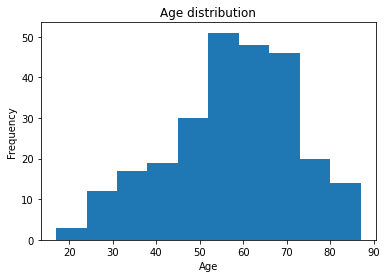

In [11]:
ax = ages.plot.hist(title="Age distribution")
ax.set_xlabel("Age")

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_19508/8445278.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  groupby_diagnosis = df.groupby(["Reason_for_admission"])['patient', 'signal_duration']


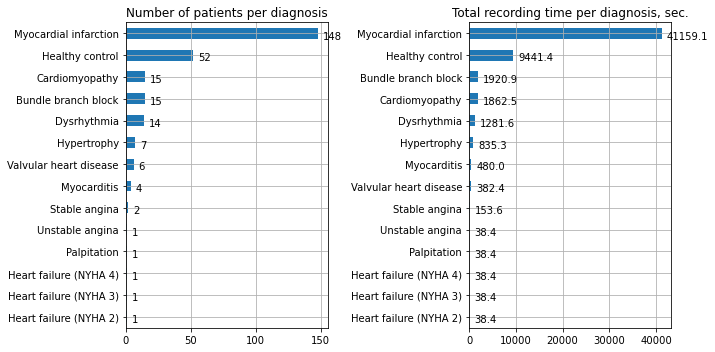

In [12]:
df["signal_duration"] = df["sig_len"] / df["fs"]

groupby_diagnosis = df.groupby(["Reason_for_admission"])['patient', 'signal_duration']
groupby_diagnosis = groupby_diagnosis.agg({"patient": 'nunique', "signal_duration": "sum"})

fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].yaxis.label.set_visible(False)
axes[1].yaxis.label.set_visible(False)

groupby_diagnosis["patient"].sort_values(ascending=True).plot(ax=axes[0], kind='barh', grid=True, figsize=(10,5), 
                                         title="Number of patients per diagnosis")

for p in axes[0].patches:
    axes[0].annotate(str(p.get_width()), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 0), textcoords='offset points')

groupby_diagnosis["signal_duration"].sort_values(ascending=True).plot(ax=axes[1], kind='barh', grid=True, figsize=(10,5), 
                                         title="Total recording time per diagnosis, sec.")

for p in axes[1].patches:
    val = "{:.1f}".format(p.get_width())
    axes[1].annotate(val, (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 0), textcoords='offset points')
    
fig.tight_layout()

# Myocardial infarction

In [13]:
df["myocardial_infarction"] = (df.Reason_for_admission == "Myocardial infarction").astype(int)

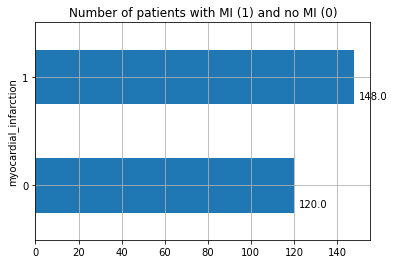

In [14]:
_t = df.groupby(["myocardial_infarction"])["patient"].nunique()
ax = _t.sort_values(ascending=True).plot(kind='barh', grid=True, 
                                      title="Number of patients with MI (1) and no MI (0)")
# ax.set_yticklabels(["MI", "Non-MI"], rotation=0)
for p in ax.patches:
    val = "{:.1f}".format(p.get_width())
    ax.annotate(val, (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 5), textcoords='offset points')

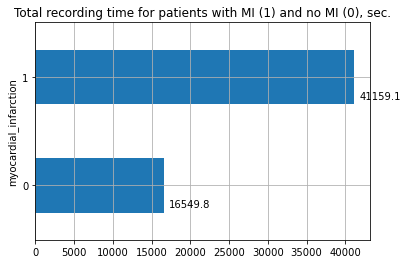

In [15]:
_t = df.groupby(["myocardial_infarction"])["signal_duration"].sum()
ax = _t.sort_values(ascending=True).plot(kind='barh', grid=True, 
                                      title="Total recording time for patients with MI (1) and no MI (0), sec.")
# ax.set_yticklabels(["MI", "Non-MI"], rotation=0)
for p in ax.patches:
    val = "{:.1f}".format(p.get_width())
    ax.annotate(val, (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 5), textcoords='offset points')

Text(0.5, 1.05, 'Age distribution for patients with no MI (0) and MI (1)')

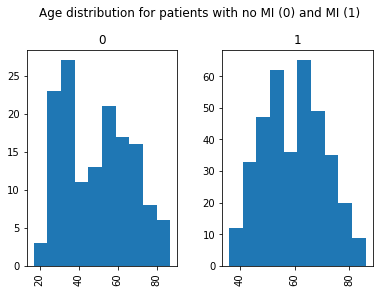

In [16]:
df['age'].hist(by=df['myocardial_infarction'], stacked=True)
plt.suptitle('Age distribution for patients with no MI (0) and MI (1)', y=1.05)

# Dysrhythmia

In [17]:
df["dysrhythmia"] = (df.Reason_for_admission == "Dysrhythmia").astype(int)

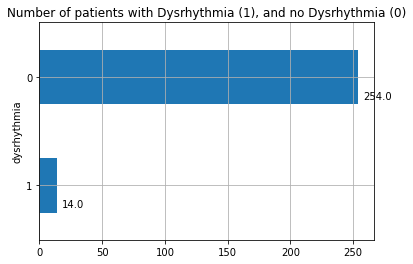

In [18]:
_t = df.groupby(["dysrhythmia"])["patient"].nunique()
ax = _t.sort_values(ascending=True).plot(kind='barh', grid=True, 
                                      title="Number of patients with Dysrhythmia (1), and no Dysrhythmia (0)")
# ax.set_yticklabels(["MI", "Non-MI"], rotation=0)
for p in ax.patches:
    val = "{:.1f}".format(p.get_width())
    ax.annotate(val, (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 5), textcoords='offset points')

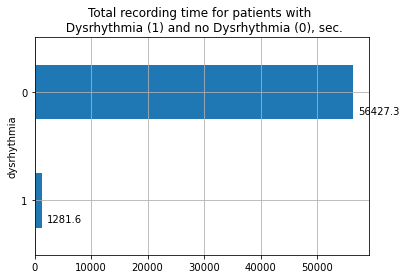

In [19]:
_t = df.groupby(["dysrhythmia"])["signal_duration"].sum()
ax = _t.sort_values(ascending=True).plot(kind='barh', grid=True, 
                                      title="Total recording time for patients with \n Dysrhythmia (1) and no Dysrhythmia (0), sec.")
# ax.set_yticklabels(["MI", "Non-MI"], rotation=0)
for p in ax.patches:
    val = "{:.1f}".format(p.get_width())
    ax.annotate(val, (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 5), textcoords='offset points')

In [20]:
df.head()

,patient,record_id,fs,sig_len,n_sig,base_date,base_time,units,sig_name,age,sex,ECG_date,Diagnose,Reason_for_admission,signal_duration,myocardial_infarction,dysrhythmia
0,patient001,s0010_re,1000,38400,15,NaN,NaN,"['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV...","['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', ...",81.0,female,01/10/1990,NaN,Myocardial infarction,38.4,1,0
1,patient001,s0014lre,1000,115200,15,NaN,NaN,"['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV...","['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', ...",81.0,female,17/10/1990,NaN,Myocardial infarction,115.2,1,0
2,patient001,s0016lre,1000,115200,15,NaN,NaN,"['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV...","['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', ...",81.0,female,18/10/1990,NaN,Myocardial infarction,115.2,1,0
3,patient002,s0015lre,1000,115200,15,NaN,NaN,"['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV...","['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', ...",58.0,female,17/10/1990,NaN,Myocardial infarction,115.2,1,0
4,patient003,s0017lre,1000,115200,15,NaN,NaN,"['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV...","['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', ...",63.0,male,18/10/1990,NaN,Myocardial infarction,115.2,1,0
